In [112]:
import pandas as pd
import json

import polka
import random

import nltk
from pymorphy2 import MorphAnalyzer
import string

import Levenshtein

import matplotlib.pyplot as plt

In [46]:
# конфигурация
with open('config.json', 'r') as file:
    config = json.load(file)

data_path = config['data_path_without_repeats']

paronyms = pd.read_csv(data_path, index_col=0)

pairs_list = paronyms[paronyms.label==1][['word1', 'word2']].values.tolist()

In [47]:
def get_random_sentence():
    book = random.choice(polka.books())
    sentences = book.description
    return sentences


def lemmatize_sentence(sentence):
    morph = MorphAnalyzer()
    words = sentence.split()

    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    lemmatized_sentence = ' '.join(lemmatized_words)

    return lemmatized_sentence

In [63]:
task = pd.DataFrame(columns = ["id", "type", "text", "difficulty"])
task.set_index("id", drop=True, inplace=True)

answer = pd.DataFrame(columns = ["id", "task_id", "text", "text_pos", "is_true"])
answer.set_index("id", drop=True, inplace=True)

In [64]:
for book in polka.books():
    sent = book.description
    clear_sent = ''.join(char for char in sent if char not in string.punctuation)
    lem_sent = lemmatize_sentence(clear_sent)
    
    for i, word in enumerate(lem_sent.split()):
        for words in pairs_list:
            have_paronym = False
            if word == words[0]:
                index_in_word_pair = 0
                have_paronym = True
            if word==words[1]:
                index_in_word_pair = 1
                have_paronym=True

            if have_paronym:
                new_task_row = {"id": len(task), "type": "paronyms", "text": sent, "difficulty": 1 - (Levenshtein.distance(word, words[1 - index_in_word_pair]) / max(len(word), len(words[1 - index_in_word_pair])))}
                new_answer_row1 = {"task_id": len(task), "text": words[index_in_word_pair], "text_pos": i, "is_true": 1}
                new_answer_row2 = {"task_id": len(task), "text": words[1 - index_in_word_pair], "text_pos": i, "is_true": 0}

                task.loc[len(task)] = pd.Series(new_task_row)
                answer.loc[len(answer)] = pd.Series(new_answer_row1)
                answer.loc[len(answer)] = pd.Series(new_answer_row2)

In [94]:
task

,type,text,difficulty
id,,,
0,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.5
1,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.625
2,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.6
3,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.733333
4,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.666667
...,...,...,...
216,paronyms,"Пьеса о странном убийстве накануне Рождества, ...",0.5
217,paronyms,Трагический текст о расставании с тайной детст...,0.636364
218,paronyms,Трагический текст о расставании с тайной детст...,0.777778


In [95]:
answer

,task_id,text,text_pos,is_true
id,,,,
0,0,единственный,0,1
1,0,единый,0,0
2,1,исток,6,1
3,1,источник,6,0
4,2,русский,7,1
...,...,...,...,...
437,218,заглавный,15,0
438,219,русский,17,1
439,219,российский,17,0


In [93]:
task.to_csv("Data/task.csv")

In [92]:
answer.to_csv("Data/answer.csv")

In [71]:
test = pd.merge(left = answer, right = task, how="left", left_on = "task_id", right_on = "id")

In [91]:
test.head(10)

,task_id,text_x,text_pos,is_true,type,text_y,difficulty
0,0,единственный,0,1,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.5
1,0,единый,0,0,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.5
2,1,исток,6,1,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.625
3,1,источник,6,0,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.625
4,2,русский,7,1,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.6
5,2,российский,7,0,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.6
6,3,психологический,8,1,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.733333
7,3,психологичный,8,0,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.733333
8,4,опасный,12,1,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.666667
9,4,опасливый,12,0,paronyms,"Единственный завершённый роман Лермонтова, сто...",0.666667


In [105]:
i = 98

In [106]:
test.iloc[i].text_y

'История о мелком чиновнике, который потерял свою единственную радость и превратился в привидение. Повесть с фантастическим финалом, из которой вышел русский реализм.'

In [107]:
list(test.iloc[i].text_y.split())[test.iloc[i].text_pos]

'единственную'

In [111]:
answer.text.nunique(), answer.shape[0]

(160, 442)

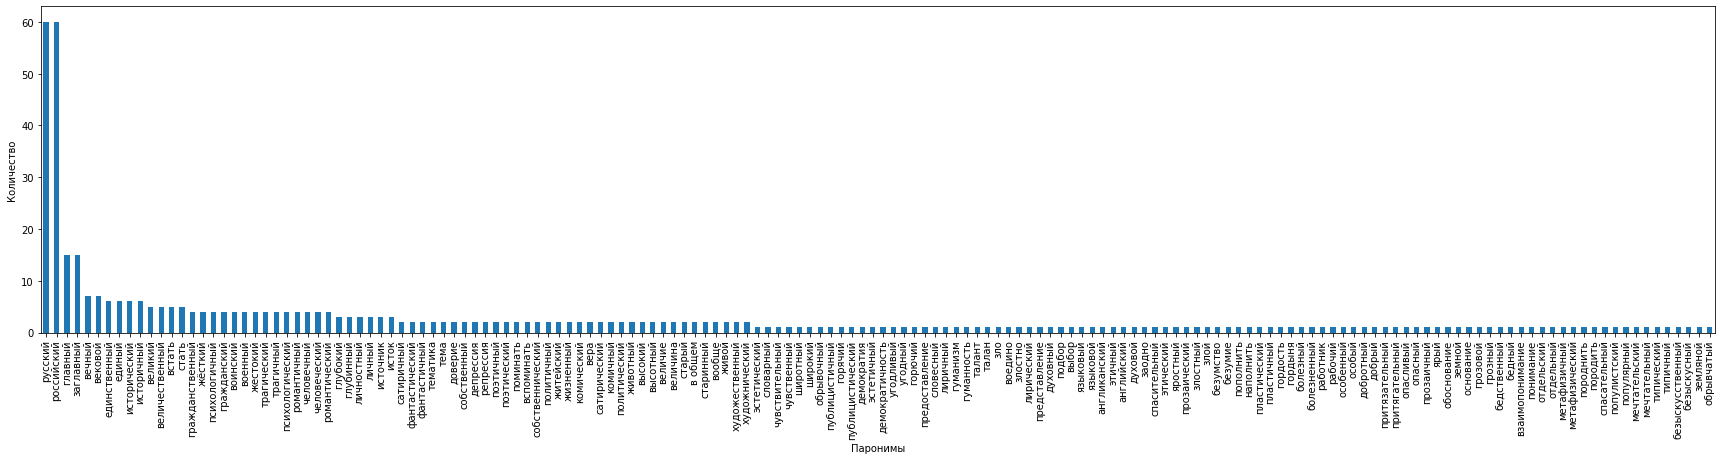

In [119]:
unique_values = answer.text.value_counts()

# строим график
plt.figure(figsize=(30, 6))
unique_values.plot(kind='bar')
plt.xlabel('Паронимы')
plt.ylabel('Количество')
plt.show()